In [82]:
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy.spatial import distance_matrix

number_cities = 10

'''
Generate city names in alphabetical order
'''
cities = []

for i in range(number_cities):
    city = chr(ord('A') + i)
    cities.append(city)

'''
Origin of the graph
'''
depot_longitude       =  -79.383292
depot_latitude        =  43.652224

'''
Generate random coordinates
'''
longitude = np.random.normal(depot_longitude, 0.1, number_cities)
latitude  = np.random.normal(depot_latitude, 0.1, number_cities)


'''
Generate random demands per cities
'''
demands = np.random.randint(1, 11, number_cities-1)
demands = np.insert(demands,0,0)
print(demands)


'''
Insert coordinates in a matrix
'''
coords  =  []
k       =  0
for citie in range(len(cities)):
    #coords.append([abs(round(longitude[k]*100000)), abs(round(latitude[k]*100000))])
    coords.append([longitude[k], latitude[k]])
    k += 1



print(coords)
df      = pd.DataFrame(coords, columns=['xcord', 'ycord'],    index=cities)
#df     = pd.DataFrame({"longitude":longitude,
#                       "latitude":latitude},  index=cities)

df_map = pd.DataFrame({"longitude":longitude,
                       "latitude":latitude,
                       "demand":demands},  index=cities)
print(df)
print("-------------------------------")
print(df_map)

[ 0  1  2  7  3  6  8 10  2  3]
[[-79.32781581310643, 43.54454860214644], [-79.56960822488915, 43.637551593431986], [-79.46011150741293, 43.53050881164206], [-79.42713244340422, 43.76886782292394], [-79.40803133126488, 43.521621361378806], [-79.33956965125024, 43.64456055496493], [-79.50597851204462, 43.64664484011698], [-79.53316569130239, 43.75332318823669], [-79.3233481469234, 43.60793642025205], [-79.30992405183763, 43.721746370664405]]
       xcord      ycord
A -79.327816  43.544549
B -79.569608  43.637552
C -79.460112  43.530509
D -79.427132  43.768868
E -79.408031  43.521621
F -79.339570  43.644561
G -79.505979  43.646645
H -79.533166  43.753323
I -79.323348  43.607936
J -79.309924  43.721746
-------------------------------
   longitude   latitude  demand
A -79.327816  43.544549       0
B -79.569608  43.637552       1
C -79.460112  43.530509       2
D -79.427132  43.768868       7
E -79.408031  43.521621       3
F -79.339570  43.644561       6
G -79.505979  43.646645       8
H -

In [92]:
longitude, latitude = coords.T                                   # We define that the first value of coords is X and the second is Y
plt.plot(longitude[0], latitude[0], c='r', marker='s')
plt.scatter(longitude[1:],latitude[1:], c='b')             # Put the x and y axis in pyplot
plt.show()                                  # Display the coordinates of the cities on an orthonormal coordinate system

AttributeError: 'list' object has no attribute 'T'

In [93]:
'''
Creation of the matrix of distances between cities
'''

matrix   = distance_matrix(df.values, df.values)
distance = pd.DataFrame(matrix, index=df.index, columns=df.index)
print(matrix)
print("--------------------------")
print(distance)

[[0.         0.25906201 0.13303859 0.24532205 0.08342774 0.10070027
  0.20534261 0.29284023 0.06354507 0.17809875]
 [0.25906201 0.         0.15312638 0.19376094 0.19886405 0.23014533
  0.06427618 0.12137183 0.24803444 0.272992  ]
 [0.13303859 0.15312638 0.         0.24062967 0.05283305 0.16594619
  0.12486536 0.23448488 0.15715995 0.24316265]
 [0.24532205 0.19376094 0.24062967 0.         0.2479832  0.15205111
  0.14544814 0.10716662 0.19149438 0.12632592]
 [0.08342774 0.19886405 0.05283305 0.2479832  0.         0.14071619
  0.15882229 0.26333314 0.12091952 0.22287902]
 [0.10070027 0.23014533 0.16594619 0.15205111 0.14071619 0.
  0.16642191 0.22205571 0.04005577 0.0826832 ]
 [0.20534261 0.06427618 0.12486536 0.14544814 0.15882229 0.16642191
  0.         0.1100882  0.18668742 0.20994664]
 [0.29284023 0.12137183 0.23448488 0.10716662 0.26333314 0.22205571
  0.1100882  0.         0.25526597 0.2254638 ]
 [0.06354507 0.24803444 0.15715995 0.19149438 0.12091952 0.04005577
  0.18668742 0.25526

In [94]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from time import time


class VPR:

    def __init__(self, capacity, demands, distance_matrix):
        self.n_trucks              =   1                          # Number of trucks
        self.dimension             =   number_cities              # Dimension of the matrix
        self.capacity              =   capacity                   # Capacity for trucks
        self.demands               =   demands                    # List of demands per edge
        self.distance_matrix       =   distance_matrix            # Distance Matrix between edge
        self.distance_matrix_sum   =   distance_matrix.sum()      # Get the sum of all the distance value
        self.final_cost            =   self.distance_matrix_sum   # Final Result / We need a first (worst) value to compare after
        self.final_sol             =   None                       # Final solution of all paths

        self.iterations            =   None                       # Number of iterations
        self.n_ants                =   None                       # Number of ants
        self.alpha                 =   None                       # alpha: exponenet on pheromone, higher alpha gives pheromone more weight
        self.beta                  =   None                       # beta: exponent on distance, higher beta give distance more weight
        self.decay                 =   None                       # decay: Rate it which pheromone decays. The pheromone value is multiplied by decay, so 0.95 will lead to decay, 0.5 to much faster decay.
        self.init_pheromone_value  =   None                       # Number of pheromone at the start in each edge
        self.pheromone_map         =   None                       # Number of pheromone per edge in a matrix
        self.raw_prob_matrix       =   None                       # Matrix of probability between edge

        self.city_visited          =   None                       # Array of 0 and 1 per city to know if you have been in a city. 0 -> visited and 1 -> not visited.
        self.city_visited_sum      =   None                       # Number of visited cities
        self.capacity_left         =   None                       # Capacity left in a truck

    def get_probality(self, raw_prob_list):
        prob_list = raw_prob_list/raw_prob_list.sum()     # PAS COMPRIS POURQUOI MAIS L AUTRE ALGO FAIT LA MEME CHOSE
        return prob_list

    def get_next_vertex(self, pos):
        potential      =  deepcopy(self.city_visited)                          # Get the visted cities list (0 -> visited and 1 -> not visited.)
        potential_sum  =  self.city_visited_sum                                # Get the number of visited cities
        while potential_sum < self.dimension:                                  # While we have not visited all the cities we continue to search the next one
            raw_prob_list  =  deepcopy(self.raw_prob_matrix[pos]) * potential  # We get the probability of each cities and we remove the cities already visited -
                                                                               # - by multiplying the potential (0 if a city is already visited)
            next_vertex    =  np.random.choice(np.arange(0, self.dimension), p=self.get_probality(raw_prob_list)) # We choose a city randomly by adding the probability per city -
                                                                                                                  # - (0 if already visited thanks to "raw_prob_list")
            if self.demands[next_vertex] <= self.capacity_left:  # Return the selected vertex if the capacity of the truck is sufficient
                return next_vertex
            potential[next_vertex]  =  0        # We remove the top because the demand is too high (we put the value 0 in the list of cities visited)
            potential_sum          +=  1        # We add the list of cities visited by 1 because we deleted the previous city from the list
        return 0                                # Once you have finally removed all the cities from the list. We return 0, that is to say the city of deposit.

    def local_update(self, i, j):      # Used to update the pheromone map and therefore the probability matrix !!! BUT ONLY FOR THE CURRENT CITY (i) AND THE NEXT ONE (j) !!!
        self.pheromone_map[i, j]  += self.decay * self.init_pheromone_value / self.distance_matrix[i, j]           # We update the pheromone map
        self.pheromone_map[j, i]   = self.pheromone_map[i, j]                                                      # We make sure that the pheromone map is symmetrical with respect to the diagonal 
                                                                                                                   # (So that A-B and B-A have the same number of pheromones in the table for example)
        self.raw_prob_matrix[i, j] = self.raw_prob_matrix[j, i] = (self.pheromone_map[i, j] ** self.alpha) * \
                                                                  ((1 / self.distance_matrix[i, j]) ** self.beta)  # We update the probability matrix thanks to the pheromone map (also symmetrically equal)

    def global_update(self, best_solution, best_cost):
        for one_path in best_solution:
            for i in range(len(one_path)-1):
                self.pheromone_map[one_path[i], one_path[i + 1]]    += self.decay * self.capacity / best_cost
                self.pheromone_map[one_path[i + 1], one_path[i]]    =  self.pheromone_map[one_path[i], one_path[i + 1]]
                self.raw_prob_matrix[one_path[i], one_path[i + 1]]  =  \
                    self.raw_prob_matrix[one_path[i + 1], one_path[i]] = \
                    (self.pheromone_map[one_path[i], one_path[i + 1]] ** self.alpha) * \
                    ((1 / self.distance_matrix[one_path[i], one_path[i + 1]]) ** self.beta)

    def get_cost(self, solution):
        current_cost = 0
        for i in range(len(solution) - 1):
            current_cost += self.distance_matrix[solution[i], solution[i + 1]]
        return current_cost

    def plot_function(self):
        box = {'facecolor': 'white',
               'edgecolor': 'black',
               'boxstyle': 'round'}
        plt.figure(figsize=(9.5, 6))
        plt.text(self.iterations - 18, self.show_iteration[4] - 60,
                 f'cost={round(self.final_cost, 2)}, \n'
                 f'iterations={self.iterations}, \n'
                 f'n_ants={self.n_ants}, \n'
                 f'alpha={self.alpha}, \n'
                 f'beta={self.beta}, \n'
                 f'decay={self.decay}, \n'
                 f'init_ph={self.init_pheromone_value}',
                 bbox=box, color='black', fontsize=12)
        plt.plot(np.arange(self.iterations), self.show_cost, 'r')
        plt.plot(np.arange(self.iterations), self.show_iteration, 'k')
        plt.grid()
        plt.title(f'Fitness function for A-n{self.dimension}-k{self.n_trucks}', fontsize=18)
        plt.xlabel('iterations')
        plt.ylabel('cost')
        plt.show()

    def compute(self, iterations, n_ants, alpha, beta, decay, init_pheromone):
        self.iterations            =  iterations
        self.n_ants                =  n_ants
        self.alpha                 =  alpha
        self.beta                  =  beta
        self.decay                 =  decay
        self.init_pheromone_value  =  init_pheromone

        self.pheromone_map         =  np.full(shape=(self.dimension, self.dimension), fill_value=self.init_pheromone_value) # We create a matrix between all the points with the number of pheromones
        np.fill_diagonal(self.pheromone_map, 0)

        np.fill_diagonal(self.distance_matrix, np.inf)

        self.raw_prob_matrix = (self.pheromone_map ** self.alpha) * ((1 / self.distance_matrix) ** self.beta)  # We create the probability matrix between each point using the formula [METTRE LE NOM DE LA FORMULE]

        self.show_iteration  =  []
        self.show_cost       =  []
        for iteration in range(self.iterations):
            time_s         = time()            # CHANGER LE TIMER ET LE METTRE AU DEBUT
            best_solution  = None
            best_cost      = self.distance_matrix_sum                    # We initialize with the worst case, the addition of the distance matrix
            for ant in range(self.n_ants):
                current_state           =   0                            # We initialize the position by the deposit as the start
                solutions               =   []                           # Matrix of the solution found by this ant (Addition of one_path_solution)
                one_path_solution       =   [0]                          # Path found for one truck
                self.capacity_left      =   self.capacity                # We initialize the remaining capacity by the basic capacity of a truck
                self.city_visited       =   np.ones(self.dimension)      # We initialize the list of cities visited by only 1 (0 -> visited and 1 -> not visited)
                self.city_visited[0]    =   0                            # We set the first value to 0 (the deposit)
                self.city_visited_sum   =   1                            # We initialize the number of city visited to 1
                while self.city_visited_sum < self.dimension:            # While we have not visited all the cities we start over
                    next_state = self.get_next_vertex(current_state)     # Get the next vertex (city)
                    if next_state == 0:                                  # "get_next_vertex" returns 0 if that there is no possible city
                        one_path_solution.append(0)                      # We add the depot city (0) at the end of the solution
                        solutions.append(one_path_solution)              # We add the path found (for one truck) to the final solution
                        one_path_solution   =  [0]                       # We delete the path and we put back 0 (the city of deposit). IT'S A NEW PATH (another truck)
                        current_state       =  0                         # We put the city where we are by the depot like the beginning
                        self.capacity_left  =  self.capacity             # We restore the basic capacity of the truck.
                        continue
                    one_path_solution.append(next_state)                 # We add the city previously found to the path
                    self.capacity_left -= self.demands[next_state]       # We remove the demand of the city in the capacity of the truck
                    self.local_update(current_state, next_state)         # We update the pheromone map and therefore the probability matrix
                    current_state                     =  next_state      # We change the city where we are located by the next city (previously selected)
                    self.city_visited[current_state]  =  0               # We put the city where we just moved in the list of visited cities (The 0 value)
                    self.city_visited_sum            +=  1               # +1 to the number of cities visited
                
                one_path_solution.append(0)                              # We add the city of deposit at the end of the path
                solutions.append(one_path_solution)                      # We add the path found to the solution
                cost = sum([self.get_cost(sol) for sol in solutions])    # We calculate the cost of the paths found and add them up
                assert all(np.unique(np.hstack(solutions)) == np.arange(self.dimension))  # 

                if cost < best_cost:                     # If the cost of the solution is lower than the cost of the BEST solution,
                    best_cost      =  cost               # the best solution is replaced by the solution found previously
                    best_solution  =  solutions

            self.global_update(best_solution, best_cost)  #
            self.show_iteration.append(best_cost)         #

            if self.final_cost > best_cost:               # If the final cost is higher than the best cost (this is necessarily the case)
                self.final_cost  =  best_cost             # We recover the best solution and its cost in the final solution
                self.final_sol   =  best_solution
                self.show_cost.append(self.final_cost)  
            else:
                self.show_cost.append(self.show_cost[-1])
            # print(f'Iterations: {iterations} | time: {round(time() - time_s, 4)}| best cost: {best_cost}')

        self.final_sol = [(np.array(x) + 1).tolist() for x in self.final_sol]
        self.n_trucks  = len(self.final_sol)

In [95]:
capacity    =  50

case = VPR(capacity, demands, matrix)
case.compute(iterations=2, n_ants=2, alpha=1, beta=1, decay=0.95, init_pheromone=1000)
print("Number of car: ", case.n_trucks)

print("Found solution:", case.final_sol)

print("Final Cost:", case.final_cost)

Number of car:  1
Found solution: [[1, 5, 9, 6, 7, 2, 8, 4, 10, 3, 1]]
Final Cost: 1.2061667393223874


In [31]:
plt.scatter(x[0], y[0], c='r', marker='s')
plt.scatter(x[1:], y[1:])
col = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
i   = 0

for truck in final_path:
    for test in range(len(truck)-1):
        dot1 = truck[test]-1
        dot2 = truck[test+1]-1
        print("Couple : ", dot1, dot2)
        plt.plot([x[dot1], x[dot2]], [y[dot1], y[dot2]], c=col[(i) % len(col)])
    i += 1
    print("---------------------")
plt.show

NameError: name 'x' is not defined

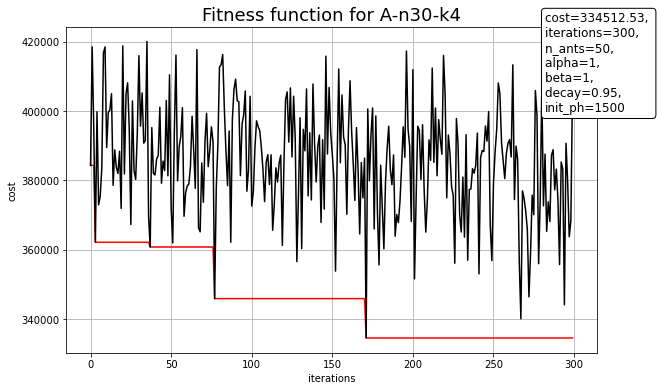

In [127]:
case.plot_function()

In [53]:
import folium
m = folium.Map(location=[43.652597, -79.384669], tiles="CartoDB positron" , zoom_start=10)

for index, row in df_map.iterrows():
    icon_house = "circle"
    color      = "blue"
    if index == "A":
        icon_house = "home"
        color      = "red"
    popup_demand = "Demand: " + str(row['demand'])
    folium.Marker(location=[row['latitude'], row['longitude']], tooltip="click for more", popup = popup_demand, icon=folium.Icon(color=color ,icon=icon_house, prefix='fa')).add_to(m)
m

In [54]:
col = ['blue', 'green', 'red', 'pink', 'orange', 'yellow', 'black', 'brown']
i   = 0

final_path = case.final_sol

for truck in final_path:
    for test in range(len(truck)-1):
        dot1 = truck[test]-1
        dot2 = truck[test+1]-1
        dot1_loc = df_map.iloc[dot1]
        dot2_loc = df_map.iloc[dot2]
        

        line = [(dot1_loc['latitude'],dot1_loc['longitude']), (dot2_loc['latitude'],dot2_loc['longitude'])]
        
        folium.PolyLine(line,
                color=col[(i) % len(col)],
                weight=5,
                opacity=0.8).add_to(m)
    i += 1

m

afficher l'ordre de passage des villes

print(matrix.sum()) --> Y UN PROBLEME C EST PAS SENCE ETRE INF

verifier les pheromones

faire un diagramme de l'algo du fourmi

FAIRE UN MODULO POUR UN CHIFFRE DE VILLE SUPERIEUR

Amelioration possible:
    - algo plus opti
    - calculer qu'il reste plus beaucoup de stockage pour eviter d'aller loin juste pour une ville et revenir